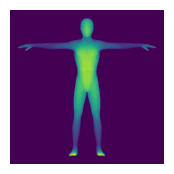

<Figure size 640x480 with 0 Axes>

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.camera_placement import front_facing_extrinsics
from text3d2video.utilities.ipython_utils import display_ims
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import FoVOrthographicCameras

from text3d2video.utilities.mesh_processing import normalize_meshes

torch.set_grad_enabled(False)

animation = AnimationArtifact.from_wandb_artifact_tag("handstand:latest")
verts_uvs, faces_uvs = animation.uv_data()
device = 'cuda'

meshes = load_objs_as_meshes(["data/meshes/mixamo-human.obj"]).to(device)
meshes = normalize_meshes(meshes)

R, T = front_facing_extrinsics(zs=1)
s = 1.8

cams = FoVOrthographicCameras(R=R, T=T, device=device, scale_xyz=[(s, s, s)])
meshes = meshes.extend(len(cams))

depth_map = render_depth_map(meshes, cams)[0]

display_ims([depth_map])

In [5]:
import torch
from diffusers import ControlNetModel

from diffusers import DPMSolverMultistepScheduler
from text3d2video.pipelines.reposable_diffusion_2D_pipeline import (
    ReposableDiffusion2DPipeline,
)

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

torch.set_grad_enabled(False)

pipe: ReposableDiffusion2DPipeline = ReposableDiffusion2DPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

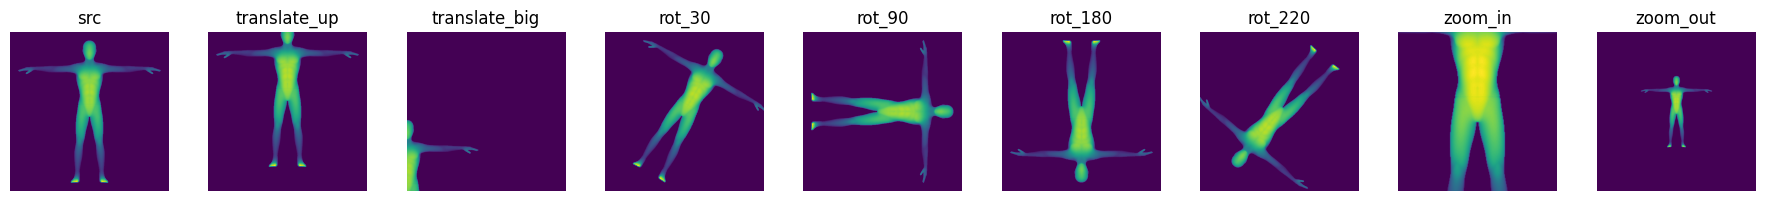

In [6]:
from text3d2video.utilities.image_utils import Affine2D
import torchvision.transforms.functional as TF

transformations = {
    "translate_up": Affine2D(translate=(-0, -0.1), scale=1, angle=0),
    "translate_big": Affine2D(translate=(-0.5, 0.5), scale=1, angle=0),
    "rot_30": Affine2D(translate=(0, 0), scale=1, angle=30),
    "rot_90": Affine2D(translate=(0, 0), scale=1, angle=90),
    "rot_180": Affine2D(translate=(0, 0), scale=1, angle=180),
    "rot_220": Affine2D(translate=(0, 0), scale=1, angle=220),
    "zoom_in": Affine2D(translate=(0, 0), scale=2, angle=0),
    "zoom_out": Affine2D(translate=(0, 0), scale=0.5, angle=0),
}

names = list(transformations.keys())
funs = list(transformations.values())

for f in funs:
    f.interpolation = TF.InterpolationMode.BILINEAR

titles = ["src"] + names
display_ims(
    [depth_map] + [f(depth_map) for f in funs],
    titles=titles,
)


In [7]:
from text3d2video.pipelines.reposable_diffusion_2D_pipeline import (
    ReposableDiffusion2DConfig,
)
from text3d2video.sd_feature_extraction import AttnType, BlockType, find_attn_layers

resolutions = [64]
hd_attn_layers = find_attn_layers(
    pipe.unet,
    block_types=[BlockType.UP],
    layer_types=[AttnType.SELF_ATTN],
    resolutions=resolutions,
)

ld_attn_layers = find_attn_layers(
    pipe.unet,
    block_types=[BlockType.DOWN],
    layer_types=[AttnType.SELF_ATTN],
    resolutions=[8, 16, 32],
)


all_attn_layers = find_attn_layers(
    pipe.unet,
    block_types=[BlockType.UP],
    layer_types=[AttnType.SELF_ATTN],
    resolutions=[8, 16, 32, 64],
)

controlnet_sa_layers = [
    "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
]

100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


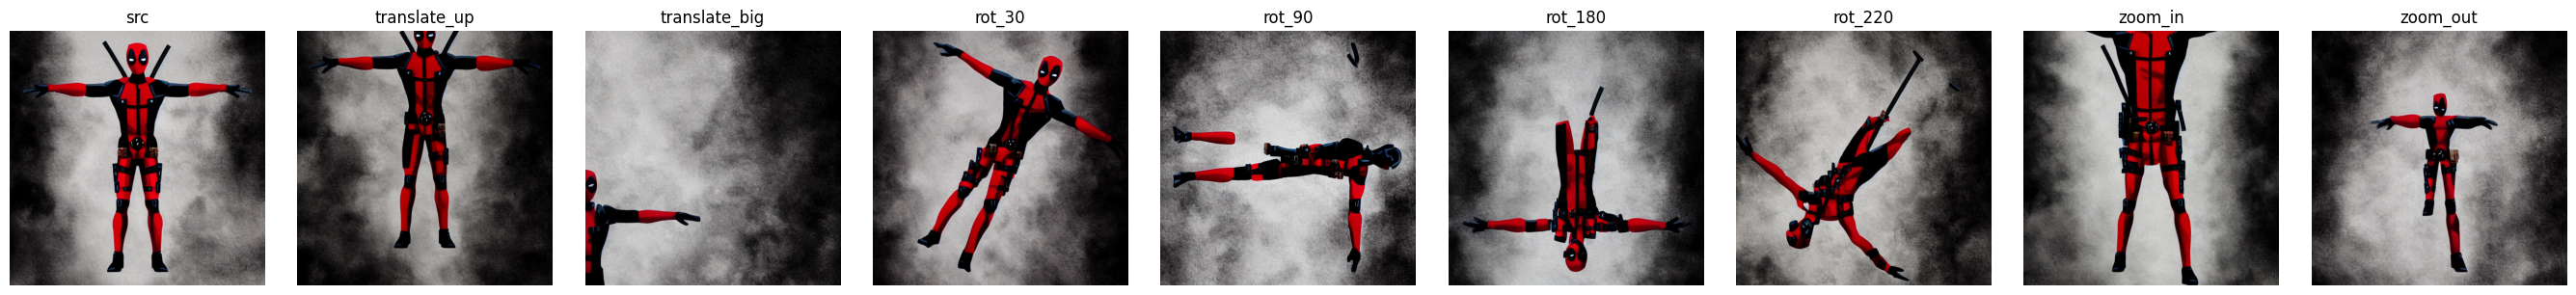

In [12]:
gen = torch.Generator(device=device)
gen.manual_seed(0)

config = ReposableDiffusion2DConfig(
    # UNet Injection
    do_kv_injection=True,
    do_qry_injection=False,
    do_post_attn_injection=False,
    spatial_extraction_layers=all_attn_layers,
    kv_extraction_layers=all_attn_layers,
    # ControlNet Injection
    do_kv_injection_controlnet=False,
    do_qry_injection_controlnet=False,
    do_post_attn_injection_controlnet=False,
    controlnet_layers=controlnet_sa_layers,
    # Overall Injection setting
    feature_blend_alpha=1.0,
    # diffusion settings
    guidance_scale=7.5,
    num_inference_steps=30,
    controlnet_conditioning_scale=1,
)

images = pipe(
    "Deadpool",
    depth_map,
    funs,
    config,
    generator=gen,
)

display_ims(images, scale=3, titles=titles)

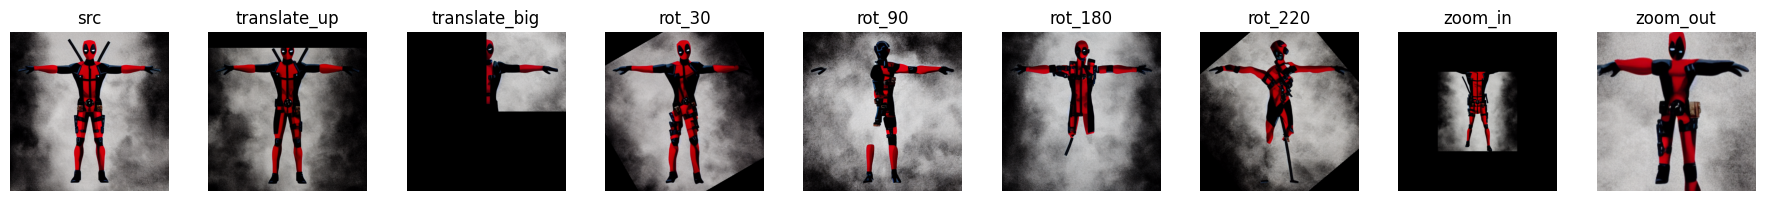

In [13]:
tgt_ims = images[1:]

warped_tgt_ims = []
for f, tgt_im in zip(funs, tgt_ims):
    warped_tgt_ims.append(f.inverse()(tgt_im))

display_ims([images[0]] + warped_tgt_ims, titles=titles)

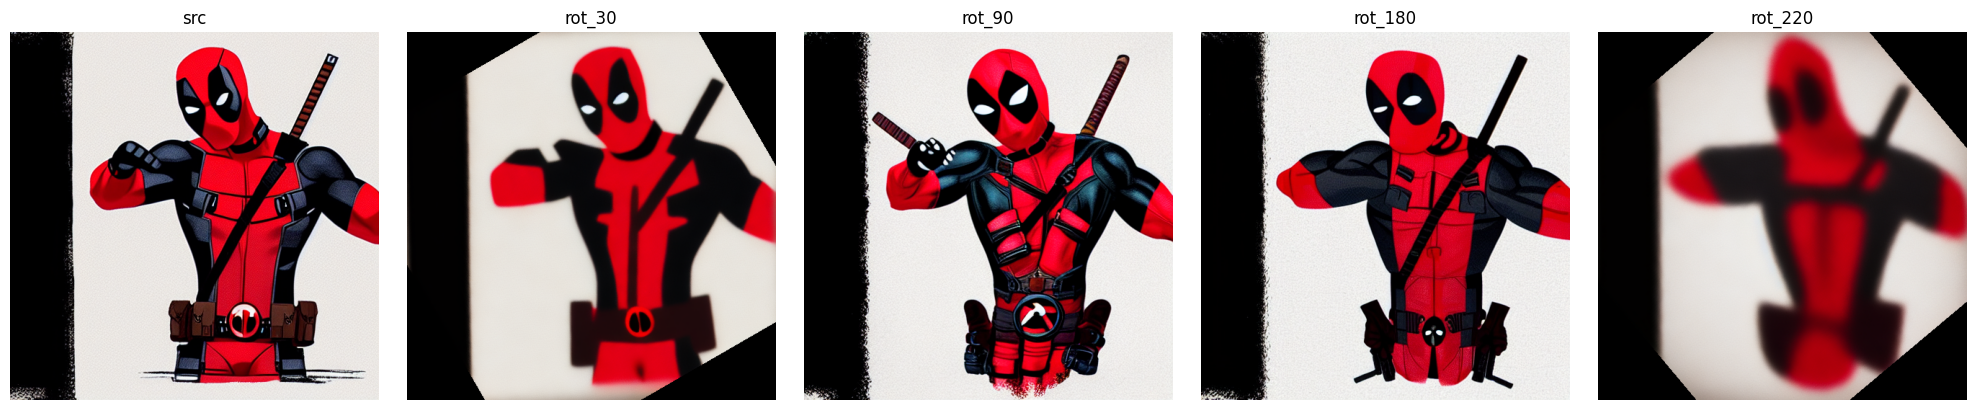

In [86]:
indices = [2,3,4,5]
display_images = [warped_tgt_ims[i] for i in indices]
display_titles = [titles[i+1] for i in indices]

display_ims([images[0]] + display_images, titles=["src"] + display_titles, scale=4)